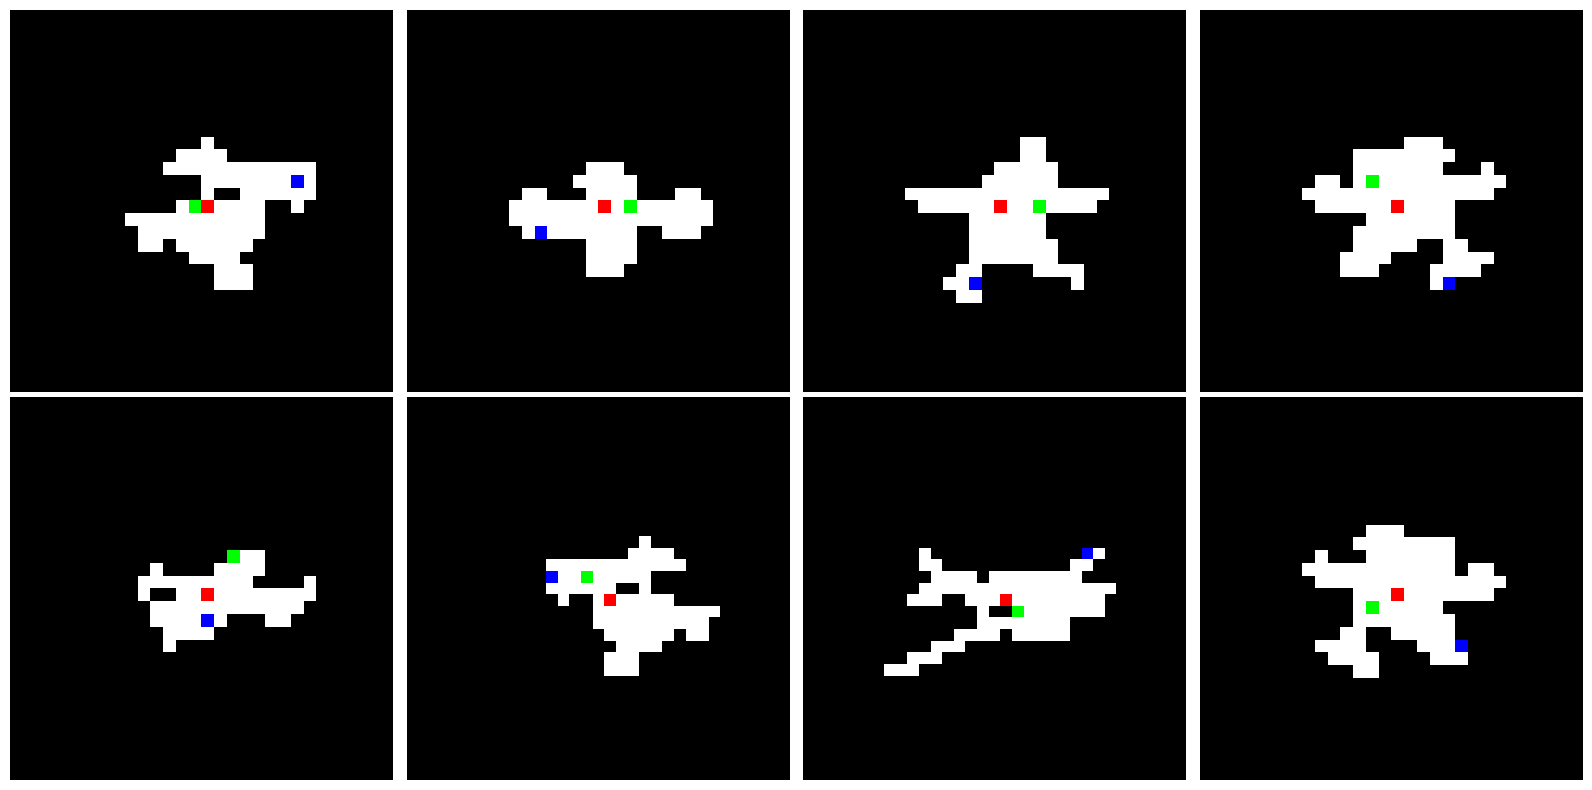

In [8]:
import scipy.ndimage

def mask2point_n(mask, offset=3):
    # 将mask和img转换为numpy数组
    base_size = mask.shape[-1]
    mask_array = np.array(mask.cpu())  # 假设mask是tensor类型

    # 使用连通组件分析找到所有独立的目标区域
    labels, num_features = scipy.ndimage.label(mask_array > 0.1)

    pts_label = torch.zeros_like(mask, dtype=torch.float32)

    for label_id in range(1, num_features + 1):
        target_mask = labels == label_id
        coords = np.argwhere(target_mask)

        if len(coords) == 0:
            continue

        masked_coords = coords

        # 计算原质心
        centroid = np.mean(coords, axis=0).astype(np.int64)
        if target_mask[centroid[0], centroid[1]] == 0:
            corrd_diff = coords - centroid
            min_dist_idx = np.argmin(np.sum(corrd_diff**2, axis=1))
            centroid = coords[min_dist_idx]

        # 找到离质心最近的亮点
        dists = np.linalg.norm(masked_coords - centroid, axis=1)
        nearest_point = masked_coords[np.argmin(dists)]
        if nearest_point.ndim > 1:
            nearest_point = nearest_point[0]

        point_y_x = nearest_point.copy()

        # 偏移：沿随机方向偏移固定距离 offset
        if offset > 0:
            theta = np.random.uniform(0, 2 * np.pi)
            # 注意坐标顺序：point_y_x = [y, x]
            ideal_y = point_y_x[0] + offset * np.sin(theta)
            ideal_x = point_y_x[1] + offset * np.cos(theta)
            ideal_point = np.array([ideal_y, ideal_x])

            # 限制在图像范围内（防止无效坐标）
            ideal_point = np.clip(ideal_point, 0, base_size - 1)

            # 在当前连通区域中找离 ideal_point 最近的前景点
            dists = np.linalg.norm(masked_coords - ideal_point, axis=1)
            nearest_point_candidate = masked_coords[np.argmin(dists)]

            # 仅当找到不同的点时才更新
            if not np.array_equal(nearest_point_candidate, point_y_x):
                point_y_x = nearest_point_candidate

        # 设置最终的点标签
        pts_label[point_y_x[0], point_y_x[1]] = 1.

    return pts_label

def mask2point(mask, img, offset=3):
    # 将mask和img转换为numpy数组
    base_size = mask.shape[-1]
    mask_array = np.array(mask.cpu())  # 假设mask是tensor类型
    img_array = np.array(img.cpu())  # H x W x C 格式

    # 使用连通组件分析找到所有独立的目标区域
    labels, num_features = scipy.ndimage.label(mask_array > 0.9)

    pts_label = torch.zeros_like(mask, dtype=torch.float32)

    for label_id in range(1, num_features + 1):
        target_mask = labels == label_id
        coords = np.argwhere(target_mask)

        if len(coords) == 0:
            continue

        # 获取目标区域内的图像像素值及其坐标
        masked_img_vals = img_array[target_mask]
        # print(masked_img_vals.shape)
        masked_coords = coords

        # 计算每个像素的亮度（例如灰度值）
        brightness = masked_img_vals.flatten()

        # 找出最亮部分的像素
        threshold = np.percentile(brightness, 50)
        bright_coords = masked_coords[brightness >= threshold]

        # 如果没有亮点，跳过
        if len(bright_coords) == 0:
            continue

        # 计算原质心
        centroid = np.mean(coords, axis=0).astype(np.int64)
        if target_mask[centroid[0], centroid[1]] == 0:
            corrd_diff = coords - centroid
            min_dist_idx = np.argmin(np.sum(corrd_diff**2, axis=1))
            centroid = coords[min_dist_idx]

        # 找到离质心最近的亮点
        dists = np.linalg.norm(bright_coords - centroid, axis=1)
        nearest_point = bright_coords[np.argmin(dists)]
        if nearest_point.ndim > 1:
            nearest_point = nearest_point[0]

        point_y_x = nearest_point.copy()

        # 偏移：沿随机方向偏移固定距离 offset
        if offset > 0:
            theta = np.random.uniform(0, 2 * np.pi)
            # 注意坐标顺序：point_y_x = [y, x]
            ideal_y = point_y_x[0] + offset * np.sin(theta)
            ideal_x = point_y_x[1] + offset * np.cos(theta)
            ideal_point = np.array([ideal_y, ideal_x])

            # 限制在图像范围内（防止无效坐标）
            ideal_point = np.clip(ideal_point, 0, base_size - 1)

            # 在当前连通区域中找离 ideal_point 最近的前景点
            dists = np.linalg.norm(bright_coords - ideal_point, axis=1)
            nearest_point_candidate = bright_coords[np.argmin(dists)]

            # 仅当找到不同的点时才更新
            if not np.array_equal(nearest_point_candidate, point_y_x):
                point_y_x = nearest_point_candidate

        # 设置最终的点标签
        pts_label[point_y_x[0], point_y_x[1]] = 1.

    return pts_label

import torch.nn.functional as F

def proper_region_square(pred, c1, c2, extend_factor=0.5, initial_size=64, mini_size=6, max_size=64):
    H, W = pred.shape
    assert 0 <= c1 < H and 0 <= c2 < W, f"Center ({c1}, {c2}) out of image bounds [{H}, {W}]"

    half_search = initial_size // 2
    min_step = mini_size // 2

    pred_padded = F.pad(pred, (half_search, half_search, half_search, half_search), value=0.0)
    pad_offset = half_search
    center_r = c1 + pad_offset
    center_c = c2 + pad_offset

    def find_boundary(center, axis, direction, other_slice):
        boundary = center + direction * half_search
        for i in range(min_step, half_search + 1):
            pos = center + direction * i
            if axis == 0:  # row-wise (top/bottom)
                start_row = max(0, pos - 1)
                end_row = min(pred_padded.shape[0], pos + 2)
                val = torch.sum(pred_padded[start_row:end_row, other_slice])
            else:  # col-wise (left/right)
                start_col = max(0, pos - 1)
                end_col = min(pred_padded.shape[1], pos + 2)
                val = torch.sum(pred_padded[other_slice, start_col:end_col])
            if val < 1.0:
                boundary = center + direction * (i - 1)
                break
        return boundary

    # Step 1: Get original bounding box
    init_col_slice = slice(center_c - half_search, center_c + half_search)
    top = find_boundary(center_r, axis=0, direction=-1, other_slice=init_col_slice)
    bottom = find_boundary(center_r, axis=0, direction=+1, other_slice=init_col_slice) + 1

    row_slice = slice(top, bottom)
    left = find_boundary(center_c, axis=1, direction=-1, other_slice=row_slice)
    right = find_boundary(center_c, axis=1, direction=+1, other_slice=row_slice) + 1

    # Convert back to original coordinates
    top_orig = max(0, top - pad_offset)
    bottom_orig = min(H, bottom - pad_offset)
    left_orig = max(0, left - pad_offset)
    right_orig = min(W, right - pad_offset)

    # Step 2: Compute minimal square radius that covers the box around (c1, c2)
    r_up = c1 - top_orig
    r_down = bottom_orig - c1
    r_left = c2 - left_orig
    r_right = right_orig - c2

    # The minimal radius to cover all sides
    r = max(r_up, r_down, r_left, r_right)

    # Apply extension
    r_extended = r * (1.0 + extend_factor)
    r_extended = max(r_extended, 1.0)  # at least 1

    # Limit by max_size
    max_radius = max_size // 2
    r_final = min(r_extended, max_radius)

    # Step 3: Build square region centered at (c1, c2)
    s1 = int(c1 - r_final)
    e1 = int(c1 + r_final)
    s2 = int(c2 - r_final)
    e2 = int(c2 + r_final)

    # Ensure within safe margins [1, H-2], [1, W-2]
    s1 = max(1, s1)
    e1 = min(H - 2, e1)
    s2 = max(1, s2)
    e2 = min(W - 2, e2)

    # Final safety: ensure non-empty
    if s1 >= e1:
        s1, e1 = max(1, c1 - 1), min(H - 2, c1 + 2)
    if s2 >= e2:
        s2, e2 = max(1, c2 - 1), min(W - 2, c2 + 2)

    return int(s1), int(e1), int(s2), int(e2)

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch

# ========== 你已有的代码（略作整理）==========
img_path = "W:/DataSets/ISTD/NUDT-SIRST/trainval/images_target"
mask_path = "W:/DataSets/ISTD/NUDT-SIRST/trainval/masks"

names = os.listdir(img_path)

masks = []
pt_labels = []

for name in names[:20]:  # 只取前8个样本用于绘图（避免太多）
    img = cv2.imread(os.path.join(img_path, name), 0)
    mask = cv2.imread(os.path.join(mask_path, name), 0)

    if img is None or mask is None:
        continue

    # ones = np.ones_like(img)
    # ones_torch = torch.from_numpy(ones)

    mask_torch = torch.from_numpy(mask).float()
    img_torch = torch.from_numpy(img).float()

    pt0_label = mask2point(mask_torch, img_torch, 0).numpy()
    pt3_label = mask2point(mask_torch, img_torch, 3).numpy()
    pt10_label = mask2point(mask_torch, img_torch, 10).numpy()

    indices = np.nonzero(pt0_label)

    # 裁剪区域
    coors = proper_region_square(mask_torch, indices[0][0], indices[1][0], 0.5)  # 注意：这里应该是 indices[1] 而不是 indices[0] 第二次！
    cropped_mask = mask[coors[0]:coors[1], coors[2]:coors[3]]
    cropped_pt0 = pt0_label[coors[0]:coors[1], coors[2]:coors[3]]
    cropped_pt3 = pt3_label[coors[0]:coors[1], coors[2]:coors[3]]
    cropped_pt10 = pt10_label[coors[0]:coors[1], coors[2]:coors[3]]

    masks.append(cropped_mask)
    pt_labels.append(np.stack([cropped_pt0, cropped_pt3, cropped_pt10], axis=0))

# 确保有至少8个样本
if len(masks) < 8:
    raise ValueError(f"Only {len(masks)} valid samples found, need at least 8.")

# ========== 新增：提取点坐标并绘图 ==========
point_coords_list = []  # 将存储 (8, 3, 2) 的坐标，若某类无点则跳过或设为 None

for i in range(8):
    mask_h, mask_w = masks[i].shape
    coords_per_sample = []
    for j in range(3):  # 三种点标签
        pt_map = pt_labels[i][j]
        pts = np.argwhere(pt_map == 1)  # shape: (N, 2), each is [row, col]
        if len(pts) > 0:
            # 取第一个点（假设每类只有一个点，符合你原始 (8,3,1,1) 设定）
            coord = pts[0]  # [row, col]
        else:
            # 如果没有点，可以设为图像中心或跳过绘制
            coord = np.array([mask_h // 2, mask_w // 2])  # fallback
        coords_per_sample.append(coord)
    point_coords_list.append(np.stack(coords_per_sample, axis=0))  # (3, 2)

# 转为 numpy array: (8, 3, 2)
point_coords = np.stack(point_coords_list, axis=0)

# ========== 绘图：将点位置的像素直接染成红、绿、蓝 ==========
colors_rgb = [
    [255, 0, 0],     # 红色 (R)
    [0, 255, 0],     # 绿色 (G)
    [0, 0, 255]      # 蓝色 (B)
]

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i in range(8):
    ax = axes[i]
    mask_gray = masks[i]  # shape: (H, W), uint8 or float
    
    # 转为 RGB 图像：先复制灰度图到三通道
    if mask_gray.dtype == np.bool_:
        mask_gray = mask_gray.astype(np.uint8) * 255
    elif mask_gray.max() <= 1.0 and mask_gray.dtype != np.uint8:
        mask_gray = (mask_gray * 255).astype(np.uint8)
    elif mask_gray.dtype != np.uint8:
        mask_gray = mask_gray.astype(np.uint8)
    
    # 创建 RGB 图像
    mask_rgb = np.stack([mask_gray, mask_gray, mask_gray], axis=-1)  # (H, W, 3)

    # 获取三种点的坐标
    for j in range(3):
        row, col = point_coords[i, j]
        # 确保坐标在图像范围内
        if 0 <= row < mask_rgb.shape[0] and 0 <= col < mask_rgb.shape[1]:
            mask_rgb[row, col] = colors_rgb[j]  # 直接修改该像素为对应颜色

    ax.imshow(mask_rgb)
    # ax.set_title(names[i], fontsize=12)
    ax.axis('off')

plt.tight_layout(pad=1.0)
plt.show()

In [8]:
# 文件名：contour_demo.py
import cv2
import numpy as np

# 尝试读取一张真实图片（比如你手机拍的几个瓶盖）
img = cv2.imread("20251024231821.jpg")  # ← 把 'your_image.jpg' 换成你的图片路径

# 1. 转灰度
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 2. 二值化（黑白图）
_, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

# 3. 找轮廓（只取最外层）
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 4. 分析每个轮廓
count = 0
for cnt in contours:
    area = cv2.contourArea(cnt)
    print(f"发现轮廓，面积 = {area:.0f} 像素")
    if area > 1000:  # 过滤掉小噪声（比如那个5x5=25像素的小点）
        count += 1
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)  # 画绿框

print(f"\n✅ 最终检测到零件数量: {count}")

# 保存结果（无需弹窗，适合所有环境）
cv2.imwrite('result.jpg', img)
cv2.imwrite('binary.jpg', thresh)
print("结果已保存为 'result.jpg'（带绿框）和 'binary.jpg'（黑白图）")

发现轮廓，面积 = 2178990 像素

✅ 最终检测到零件数量: 1
结果已保存为 'result.jpg'（带绿框）和 'binary.jpg'（黑白图）
